In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

## Load training dataset

In [2]:
# Root
from CustomDataset import CustomDataset

root = '../../train_val_test_dataset/IEEE_Case118/agg_Shedding_zero_reserve/'

# Load all data with empty input
dataset = CustomDataset(root=root, data_list=[])

# Set train and test size
train_size = 931
test_size = 200

# Set batch size
batch_size = 10

# Get train dataset
train_dataset = dataset[:train_size]
# Create train loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set hyper-parameters
input_dim = 24
hidden_dim = 256
output_dim = 12

# Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## SAGE

In [4]:
from GNNAggPGRegressor import AggPGSAGE

# Initialize the model
model = AggPGSAGE(input_dim, hidden_dim, output_dim)
model.to(device)

AggPGSAGE(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
  )
  (gnn): Sequential(
    (0): SAGEConv(256, 256, aggr=mean)
    (1): ReLU()
    (2): SAGEConv(256, 256, aggr=mean)
    (3): ReLU()
    (4): SAGEConv(256, 256, aggr=mean)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=48, bias=True)
  )
)

#### SAGE model training

c:\Users\zhay109\.conda\envs\PyG-gpu\Lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


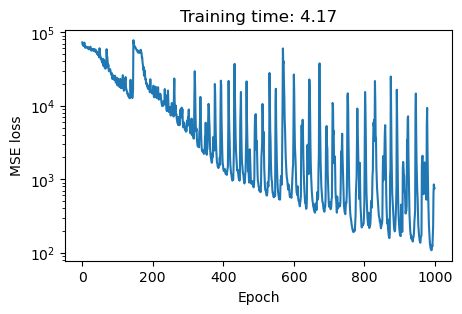

In [5]:
epochs = 1000

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index, loader.batch)

        loss = F.mse_loss(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save SAGE model

In [6]:
torch.save(model, f'../../trained_model/IEEE_Case118/agg_Shedding_zero_reserve_model.pt')

#### SAGE model testing

In [7]:
unit_length = 4
model_path = f'../../trained_model/IEEE_Case118/agg_Shedding_zero_reserve_model.pt'
model = torch.load(model_path)
model.to('cpu')

model.eval()

# Complete dataset
test_dataset = dataset[-test_size:]
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.cpu().detach().numpy()
        # Save ground true
        for j in range(batch_size):
            file_path = f'../../res/IEEE_Case118/model_evaluation/agg_Shedding_zero_reserve/true/true_{i*batch_size+j+1}.csv'
            pd.DataFrame(ground_true[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index, loader.batch)
        pred = pred.cpu().detach().numpy()

        # Save prediction
        for j in range(batch_size):
            file_path = f'../../res/IEEE_Case118/model_evaluation/agg_Shedding_zero_reserve/pred/pred_{i*batch_size+j+1}.csv'
            pd.DataFrame(pred[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)